In [1]:
import numpy as np
import random as random
import pandas as pd
import matplotlib.pyplot as plt

# classes to create, store and manage sudokus including a solver
from sudoku import Sudoku
from sudoku import Solver

# numbers dataset
from keras.datasets import mnist

# import of .png
import matplotlib.image as mpimg

# for manipulation of the sudoku images
import cv2

# for browsing files
import os

Using TensorFlow backend.


### Generate Training Data

In [508]:
def save_img(img, PATH, size=(28,28)):
#     add functionality to center number before here
    img_resized = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
    np.savetxt(PATH, img_resized)
    
    
def permutate_img(img, translate_by=(0,0), shrink_by=0, noise_params=(0,0)):
    # zoom / shrink
    if shrink_by > 0:
        img = np.pad(img, pad_width=shrink_by, constant_values=1)
    if shrink_by < 0:
        img = img[:shrink_by,:shrink_by]
    else:
        pass
    
    # translate
    M = np.float32([[1,0,translate_by[0]],[0,1,translate_by[1]]])
    img = cv2.warpAffine(img,M,img.shape, borderValue=1)
    
    # add functionality to blur the image
    
    # add noise 
    noise = np.random.normal(noise_params[0], noise_params[1], img.shape)
    img = img-noise
    img[img < 0] = 0
    img[img > 1] = 1
    
    
    return img

def generate_trainingdata(imgs, labels, PATH, translation_range, shrinkage_range, noise_range, n_copies, size=(28,28)):
    for n in range(n_copies):
        rand_translation = np.random.randint(translation_range[0], translation_range[1],2)
        rand_shrinkage = np.random.randint(translation_range[0], translation_range[1])
        rand_noise = (noise_range[0] + noise_range[1]%np.random.random(1), noise_range[2] + noise_range[3]%np.random.random(1))
        for index, img in enumerate(imgs):
            permutated_img = permutate_img(img, rand_translation, rand_shrinkage, rand_noise)
            filename = PATH + "x_" + str(labels[index]) + "_" + str(index) + "_" + str(n) + ".txt"
            save_img(permutated_img, filename, size)
            
def centerpad_num(num_img, pad=0):
    ys = np.argwhere(1-np.mean(num_img, axis = 0) > 1*10e-3)
    xs = np.argwhere(1-np.mean(num_img, axis = 1) > 1*10e-3)
    num_img_cropped = num_img[int(xs[0]):int(xs[-1]+1),int(ys[0]):int(ys[-1]+1)]
    diff_dim = abs(int(np.diff(num_img_cropped.shape)))    
    num_img_sym = np.pad(num_img_cropped, pad_width=[[0,0],[int(diff_dim/2),int(diff_dim/2)+diff_dim%2]], constant_values=1)
    if pad > 0:
        num_img = np.pad(num_img_sym, pad_width=pad, constant_values=1)
    else:
        num_img = num_img_sym
    return num_img

In [521]:
numbers1 = mpimg.imread("numbers.png")
numbers2 = mpimg.imread("numbers2.png")
pad_with = 6
numbers2[370:450,5*53+39:(5+1)*53-13,0] = 1 # removes cursor black bar in img of 6
for i in range(9):
    save_img(centerpad_num(numbers1[:70,i*58:(i+1)*58,0], pad_with), "./numbers/0_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[100:200,i*80:(i+1)*80-10,0], pad_with), "./numbers/1_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[250:340,i*62:(i+1)*62,0], pad_with), "./numbers/2_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[335:410,i*85:(i+1)*85-25,0], pad_with), "./numbers/3_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[430:510,i*66:(i+1)*66,0], pad_with), "./numbers/4_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[530:620,i*68:(i+1)*68,0], pad_with), "./numbers/5_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[640:760,i*64:(i+1)*64-5,0], pad_with), "./numbers/6_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers1[750:,i*85:(i+1)*85-25,0], pad_with), "./numbers/7_" + str(i+1)+".txt", (28,28))

    save_img(centerpad_num(numbers2[:50,i*55:(i+1)*55-20,0], pad_with), "./numbers/8_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[80:150,i*50:(i+1)*50,0], pad_with), "./numbers/9_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[180:250,i*57:(i+1)*57-10,0], pad_with), "./numbers/10_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[290:350,i*67:(i+1)*67-20,0], pad_with), "./numbers/11_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[370:450,i*53:(i+1)*53,0], pad_with), "./numbers/12_" + str(i+1)+".txt", (28,28)) # black bar at 6 <-- cursor
    save_img(centerpad_num(numbers2[460:520,i*53:(i+1)*53-10,0], pad_with), "./numbers/13_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[560:640,i*65:(i+1)*65-15,0], pad_with), "./numbers/14_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[680:750,i*77:(i+1)*77-30,0], pad_with), "./numbers/15_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[760:820,i*74:(i+1)*74,0], pad_with), "./numbers/16_" + str(i+1)+".txt", (28,28)) # causes problems to divide cleanly, not equally spaced
    save_img(centerpad_num(numbers2[860:920,i*53:(i+1)*53-10,0], pad_with), "./numbers/17_" + str(i+1)+".txt", (28,28))
    save_img(centerpad_num(numbers2[930:,i*53:(i+1)*53-10,0], pad_with), "./numbers/18_" + str(i+1)+".txt", (28,28))

for k in range(19):
    np.savetxt("./numbers/" + str(k) + "_0" +".txt", np.ones([28,28]))    

In [ ]:
# # loading mnist digits dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# # replace zeros by empty cell
# x_train[y_train[:] == 0] = np.zeros([28,28])
# x_test[y_test[:] == 0] = np.zeros([28,28])

# # rescaling from RGB Values to between 0-1
# x_train = x_train/255
# x_test = x_test/255

In [522]:
numbers = []
labels = []
for file in os.listdir("./numbers/"):
    numbers.append(np.loadtxt("./numbers/" + file))
    labels.append(int(file[-5:-4]))
numbers = np.array(numbers)

In [523]:
# plt.imshow(permutate_img(numbers[1], translate_by = (0,3), shrink_by=0, noise_params=(0.5,0.2)))
generate_trainingdata(numbers, labels, "./x_train/",(-3,3), (0,3), (0,0.5,0.0,0.2), 50)

In [515]:
# numbers2[370:450,5*53+39:(5+1)*53-13,0] = 1 # removes cursor black bar in img of 6
# i = 1
# plt.imshow(centerpad_num(numbers1[:70,i*58:(i+1)*58,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[100:200,i*80:(i+1)*80-10,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[250:340,i*62:(i+1)*62,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[335:410,i*85:(i+1)*85-25,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[430:510,i*66:(i+1)*66,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[530:620,i*68:(i+1)*68,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[640:760,i*64:(i+1)*64-5,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers1[750:,i*85:(i+1)*85-25,0], pad_with))
# plt.show()

# plt.imshow(centerpad_num(numbers2[:50,i*55:(i+1)*55-20,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[80:150,i*50:(i+1)*50,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[180:250,i*57:(i+1)*57-10,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[290:350,i*67:(i+1)*67-20,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[370:450,i*53:(i+1)*53,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[460:520,i*53:(i+1)*53-10,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[560:640,i*65:(i+1)*65-15,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[680:750,i*77:(i+1)*77-30,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[760:820,i*74:(i+1)*74,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[860:920,i*53:(i+1)*53-10,0], pad_with))
# plt.show()
# plt.imshow(centerpad_num(numbers2[930:,i*53:(i+1)*53-10,0], pad_with))
# plt.show()


# for index, number in enumerate(numbers):
#     if labels[index] == 6:
#         plt.imshow(number)
#     plt.show()

### Load Training Data

In [524]:
X = []
y = []
for file in os.listdir("./x_train/"):
    X.append(np.loadtxt("./x_train/" + file))
    y.append(int(file[-5:-4]))
X = np.array(X)

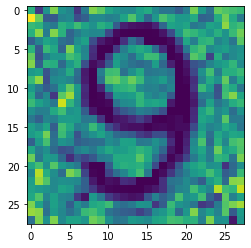

In [534]:
plt.imshow(X[24])

### Generate sudokus for validation of the algorithms

In [535]:
def fill_squares(grid, square_size, grid_thickness, square_grid_thickness, mode, data=None, noise=(0.0,0.0)):
    """ This function takes a NxN array with typical sudoku gridlines, its edge thicknesses
        and square sizes. It then fills the square spaces between this gridlines, depending on the 
        selected mode:
        - 'none'  ---> leaves squares empty.
        - 'noise'  --> fills squares with noise.
        - 'numbers' -> fills squares with random numbers from a provided dataset.
        - 'sudoku' --> fills squares according to a sudoku, downloaded from the web.
        
        ."""
    if mode == "sudoku":
        sudoku = Sudoku()
        sudoku.download_new()
    
    for i in np.arange(9):
        pos_i = i*square_size + (i-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness
        for j in np.arange(9):
            pos_j = j*square_size + (j-int(j/3))*grid_thickness  + int(j/3)*square_grid_thickness
            
            if mode == "noise":
                square_noise = np.random.normal(noise[0],noise[1],[square_size,square_size])
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size]- square_noise
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size][grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] < 0] = 0
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size][grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] > 1] = 1
                
            elif type(data) is not type(None):
                if mode == "numbers":
                    digits, labels = data
                    rand_num = digits[np.random.randint(digits.shape[0])]
                    rand_num = cv2.resize(rand_num, (square_size,square_size), interpolation = cv2.INTER_AREA)

                    if np.random.rand() > 0.5:
                        grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = rand_num
                    else:
                        grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.ones([square_size,square_size])

                elif mode == "sudoku":
                    digits, labels = data
                    num_indices = np.argwhere(labels == sudoku.starting_state[i,j])
                    num_indices = num_indices.reshape(num_indices.shape[0])
                    rand_num = digits[np.random.choice(num_indices)]
                    rand_num = cv2.resize(rand_num, (square_size,square_size), interpolation = cv2.INTER_AREA)

                    grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = rand_num
                
            else:
                if mode != "none":
                    print("dataset is might be missing")
                grid[pos_i:pos_i+square_size,pos_j:pos_j+square_size] = np.ones([square_size,square_size])
    
    return grid

def create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                       filling_data, square_noise=(0,0), filling_mode="none"
                      ):
    
    grid_size = 6*grid_thickness + 9*square_size + 2*square_grid_thickness
    background_size = grid_size+2*grid_border_thickness

    background = np.ones([grid_size, grid_size])
    vline = grid_alpha*np.zeros([grid_size, grid_thickness])
    hline = vline.T
    vline_ = grid_alpha*np.zeros([grid_size, square_grid_thickness])
    hline_ = vline_.T
    
    for i in np.arange(8):
        pos = (i+1)*square_size + (i-int(i/3))*grid_thickness  + int(i/3)*square_grid_thickness
        if i in [0,1,3,4,6,7]:
            background[pos:pos+grid_thickness,:] = hline
            background[:,pos:pos+grid_thickness] = vline
            
        else:
            background[pos:pos+square_grid_thickness,:] = hline_
            background[:,pos:pos+square_grid_thickness] = vline_
            
    background = fill_squares(background, square_size, grid_thickness, square_grid_thickness, filling_mode, filling_data, square_noise)

    background = np.pad(background, pad_width=grid_border_thickness, constant_values=border_alpha)
    
    background_noise = np.random.normal(noise[0], noise[1], [background_size,background_size])
    background = background-background_noise
    background[background < 0] = 0
    background[background > 1] = 1
    
    return background

def create_training_image(sudoku_grid, canvas_size, output_dim=(128,128), offcenter=(0,0), background_noise=(0.0,0.0), rotation=0):
    offcenter = np.array(offcenter)
    canvas = np.ones([canvas_size, canvas_size])
    canvas_noise = np.random.normal(background_noise[0], background_noise[1], [canvas_size,canvas_size])
    canvas = canvas-canvas_noise
    canvas[canvas < 0] = 0
    canvas[canvas > 1] = 1
    
    sudoku_size=sudoku_grid.shape[0]
    center = int(canvas_size/2-sudoku_size/2)
    if sudoku_size%2 != 0:
        offcenter[offcenter+center+sudoku_size > canvas_size] = canvas_size - center - sudoku_size - 1
        offcenter[offcenter+center < 0] = -center
    else:
        offcenter[offcenter+center+sudoku_size > canvas_size] = canvas_size - center - sudoku_size - 1
        offcenter[offcenter+center < 0] = -center + 1
    
    canvas[center+offcenter[0]:center+offcenter[0]+sudoku_size,center+offcenter[1]:center+offcenter[1]+sudoku_size] = sudoku_grid
    
    # rotate image
    M = cv2.getRotationMatrix2D((canvas.shape[0]/2+offcenter[0],canvas.shape[1]/2+offcenter[1]),rotation,1)
    canvas = cv2.warpAffine(canvas,M,canvas.shape, borderValue=-1)
    
    # add noise back to the edges caused by rotation
    if canvas_noise.any() != 0 and rotation > 0:
        corner_noise = np.random.normal(background_noise[0],background_noise[1],canvas[canvas < 0].shape[0])
        canvas[canvas < 0] = canvas[canvas < 0] - corner_noise + 2
        canvas[canvas < 0] = 0
        canvas[canvas > 1] = 1
    
    # resize image
    canvas_resized = cv2.resize(canvas, output_dim, interpolation = cv2.INTER_AREA)
    return canvas_resized

In [536]:
square_size = np.random.randint(16,22)
grid_thickness = np.random.randint(1,3)
square_grid_thickness = grid_thickness + np.random.randint(1,3)
grid_border_thickness = np.random.randint(1,6)
grid_alpha = 1
border_alpha = 0
noise = (0.0,0.0)
canvas_size_in = 256
canvas_size_out = 256
offcenter = (np.random.randint(-12,12),np.random.randint(-12,12))
canvas_noise = (0.5,0.2)
rotation = 0

sudoku_grid = create_sudoku_grid(square_size, grid_thickness, square_grid_thickness, grid_border_thickness, grid_alpha, border_alpha, noise,
                                (numbers,labels), filling_mode="sudoku")
sudoku_img = create_training_image(sudoku_grid, canvas_size_in, (canvas_size_out,canvas_size_out), offcenter, canvas_noise, rotation)

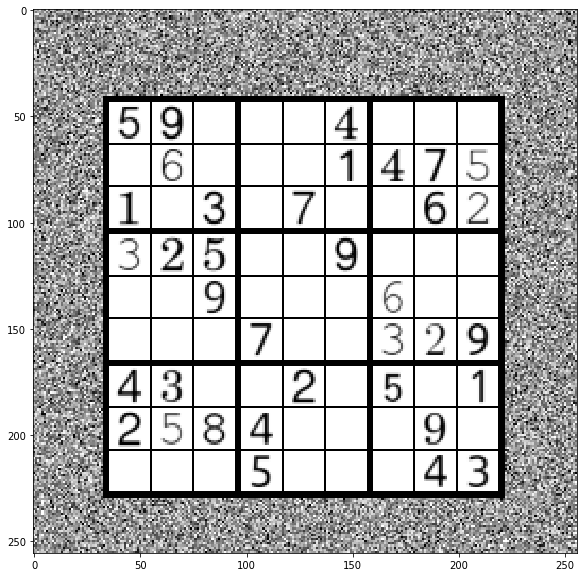

In [541]:
plt.figure(figsize=(10,10))
plt.imshow(1-sudoku_img, cmap="Greys")
plt.show()

### Identify sudoku in image, detect edges and segment it